# Forecasting Rainfall with LSTM Recurrent Neural Networks (12)
## 1 . Environment

In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)

# numpy
import numpy as np
print('numpy: %s' % np.__version__)

# matplotlib
import matplotlib.pylab as plt
print('matplotlib: %s' % plt.__version__)

# seaborn
import seaborn as sns
print('seaborn: %s' % sns.__version__)

# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)

# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

# statsmodels
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
print('statsmodels: %s' % statsmodels.__version__)

#pymongo
import pymongo
import pprint
print('pymongo: %s' % pymongo.__version__)


#json
from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import json

import itertools
import warnings

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

scipy: 0.19.1
numpy: 1.13.3
matplotlib: 1.13.3
seaborn: 0.8.0
pandas: 0.20.3
sklearn: 0.19.1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


statsmodels: 0.8.0
pymongo: 3.4.0


In [2]:
import numpy
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-2*look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + 2*look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

## 2. Extracting Data and Transforming Data

In [28]:
# Cria conexão com o Banco de Dados
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

# Cria Instância do Banco de Dados
db = client.AgroAnalyticsDatum

,rainfall.rainfall
analysis_date,
2000-03-01,3.806452
2000-04-01,0.566667
2000-05-01,0.677419
2000-06-01,0.133333
2000-07-01,1.967742


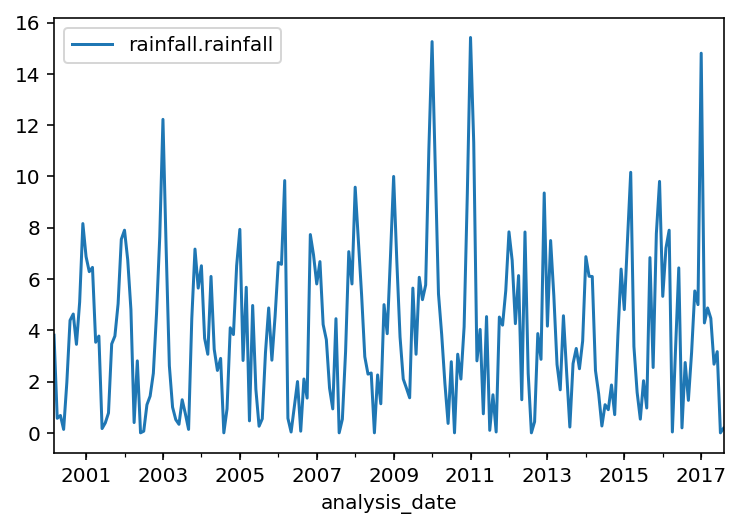

In [29]:
# Extrai dados Climáticos da Estação Selecionada
weather = list(db.meteo_data_weather_data.find({'weather_station_id': ObjectId('598f58415718dd578b4c8255')}))
weather_normalized = pd.io.json.json_normalize(weather)
df_rainfall = pd.DataFrame(weather_normalized[['analysis_date', 'rainfall.rainfall']])
df_rainfall = df_rainfall.set_index('analysis_date')
ts_rainfall = df_rainfall['2000-03-01':'2017-08-11'].groupby(pd.TimeGrouper(freq='MS')).mean()
ts_rainfall.plot()
ts_rainfall.head()

In [30]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [53]:
dataset = ts_rainfall.values
dataset = dataset.astype('float32')
# normalizando o dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [54]:
# split into train and test sets
test_size = 36
train_size = len(dataset) - 36
train, test = dataset[0:train_size+24,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

198 36


In [55]:
# reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [56]:
testX.shape

(12, 12)

In [57]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [58]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, 12)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0347
Epoch 2/100
 - 0s - loss: 0.0262
Epoch 3/100
 - 0s - loss: 0.0239
Epoch 4/100
 - 0s - loss: 0.0233
Epoch 5/100
 - 0s - loss: 0.0228
Epoch 6/100
 - 0s - loss: 0.0225
Epoch 7/100
 - 0s - loss: 0.0227
Epoch 8/100
 - 0s - loss: 0.0221
Epoch 9/100
 - 0s - loss: 0.0221
Epoch 10/100
 - 0s - loss: 0.0216
Epoch 11/100
 - 0s - loss: 0.0214
Epoch 12/100
 - 0s - loss: 0.0215
Epoch 13/100
 - 0s - loss: 0.0216
Epoch 14/100
 - 0s - loss: 0.0211
Epoch 15/100
 - 0s - loss: 0.0215
Epoch 16/100
 - 0s - loss: 0.0209
Epoch 17/100
 - 0s - loss: 0.0211
Epoch 18/100
 - 0s - loss: 0.0210
Epoch 19/100
 - 0s - loss: 0.0209
Epoch 20/100
 - 0s - loss: 0.0207
Epoch 21/100
 - 0s - loss: 0.0206
Epoch 22/100
 - 0s - loss: 0.0202
Epoch 23/100
 - 0s - loss: 0.0204
Epoch 24/100
 - 0s - loss: 0.0206
Epoch 25/100
 - 0s - loss: 0.0205
Epoch 26/100
 - 0s - loss: 0.0204
Epoch 27/100
 - 0s - loss: 0.0203
Epoch 28/100
 - 0s - loss: 0.0202
Epoch 29/100
 - 0s - loss: 0.0201
Epoch 30/100
 - 0s - lo

In [59]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [60]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [61]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))

Train Score: 2.03367 RMSE
Test Score: 2.48794 RMSE


In [62]:
# shift train for plotting
trainPlot = scaler.inverse_transform(dataset[:len(trainPredict)+2*look_back])

In [63]:
# shift test for plotting
testPlot = numpy.empty_like(dataset)
testPlot[:, :] = numpy.nan
testPlot[len(trainPredict)+(look_back*2)-1:len(dataset)-1, :] = scaler.inverse_transform(dataset[len(trainPredict)+(look_back*2)-1:len(dataset)-1])

In [64]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset[:len(dataset)-12])
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[24:len(trainPredict)+48, :] = trainPredict

In [65]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset[len(trainPredict)+24:len(dataset)])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[:len(dataset), :] = testPredict

In [66]:
testPredictPlot.shape

(12, 1)

In [67]:
Predict = numpy.append(trainPredictPlot, testPredictPlot)
Predict

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
         2.79466128,   2.3216958 ,   2.67546916,   2.62361836,
         1.72988129,   2.03847909,   2.26566219,   2.84234643,
         6.53815889,   7.29362011,   8.54471111,   7.68969393,
         5.53488111,   3.5858376 ,   1.97026944,   2.1966064 ,
         1.68950307,   1.68255305,   2.48656321,   3.49421859,
         6.87582254,   7.03962755,   8.53467274,   7.49114513,
         4.37305355,   2.79369068,   2.00415087,   2.62675548,
         2.20061088,   0.5539068 ,   1.98263061,   4.58754015,
         6.49579716,   9.27238274,   8.76199341,   5.57835245,
         3.07633209,   2.55687523,   1.9290539 ,   1.65

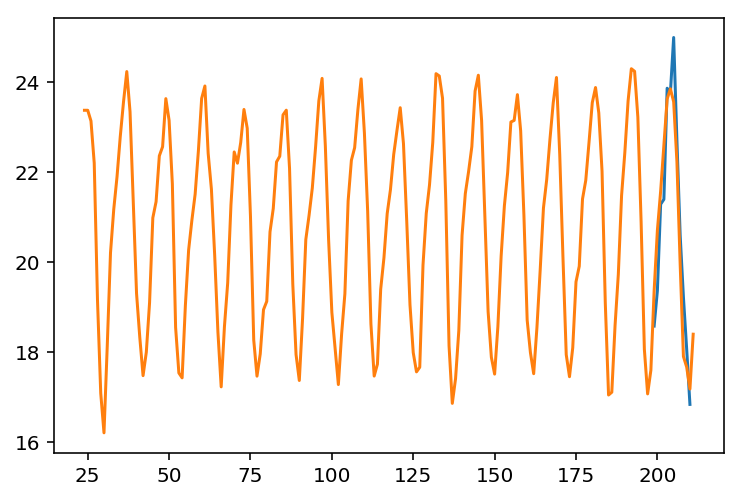

In [44]:
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset[len(trainPredict)+(look_back*2)+1:len(dataset)-1]))
#plt.plot(trainPlot)
plt.plot(testPlot)
plt.plot(Predict)
plt.show()

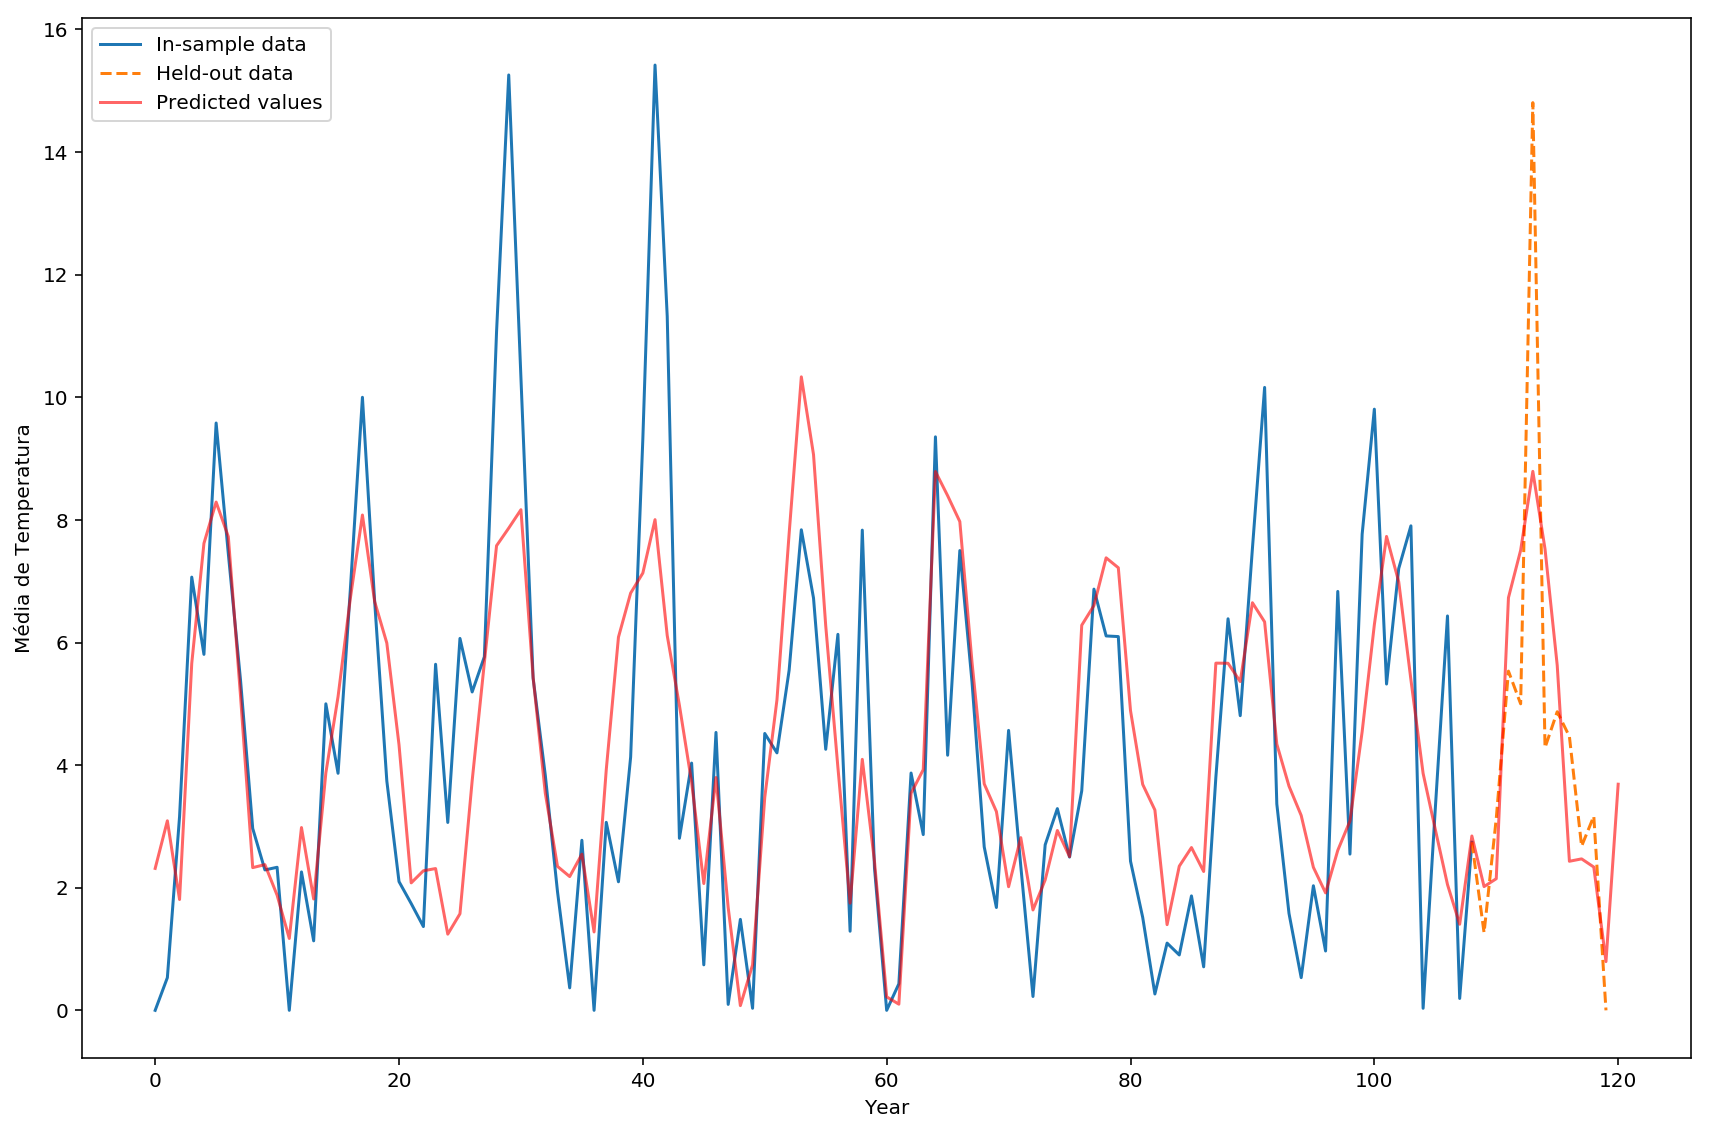

In [68]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(trainPlot[len(dataset)-121:], label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(testPlot[len(dataset)-121:], label='Held-out data', linestyle='--')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(Predict[len(dataset)-121:], 'r', alpha=.6, label='Predicted values')

ax1.set_xlabel("Year")
ax1.set_ylabel("Média de Temperatura")
ax1.legend(loc='best');
fig.tight_layout();

In [69]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

In [70]:
# Training Set

rmse = get_rmse(trainY[0], trainPredict[:,0])
print("RMSE: ", rmse)

mape = get_mape(trainY[0], trainPredict[:,0])
print("MAPE: ", mape)

RMSE:  2.03367374776
MAPE:  inf


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


In [71]:
# Test Set

rmse = get_rmse(testY[0], testPredict[:,0])
print("RMSE: ", rmse)

mape = get_mape(testY[0], testPredict[:,0])
print("MAPE: ", mape)

RMSE:  2.4879427399
MAPE:  inf


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
